In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
def demand_sales_dgp(rng_key, n):
    t = jnp.arange(start=0, stop=n, step=1)
    demand = 2 * jnp.ones_like(t, dtype=jnp.float32)
    sales = jnp.zeros_like(t, dtype=jnp.float32)
    sales_obs = jnp.zeros_like(t, dtype=jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    noise_demand = 0.3 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    noise_sales = 0.5 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    is_available = random.bernoulli(rng_subkey, 0.88, shape=(t.size,)).astype(
        jnp.float32
    )

    for i in range(2, t.size):
        demand_i = (
            0.6 * demand[i - 1]
            + 0.3 * demand[i - 2]
            + 0.6 * jnp.sin(2 * jnp.pi * t[i] / 7)
            + 0.2
            + noise_demand[i]
        )
        demand_i = jnp.maximum(demand_i, 0)
        demand = demand.at[i].set(demand_i)  # noqa

        sales_i = demand[i] + noise_sales[i] - 0.2
        sales_i = jnp.minimum(sales_i, demand_i)
        sales_i = jnp.maximum(sales_i, 0)
        sales_i_obs = is_available[i] * sales_i
        sales_i_obs = jnp.minimum(sales_i_obs, 2.2)
        sales = sales.at[i].set(sales_i)  # noqa
        sales_obs = sales_obs.at[i].set(sales_i_obs)  # noqa

    return t, demand, sales, sales_obs, is_available


n = 180
rng_key, rng_subkey = random.split(rng_key)
t, demand, sales, sales_obs, is_available = demand_sales_dgp(rng_subkey, n)

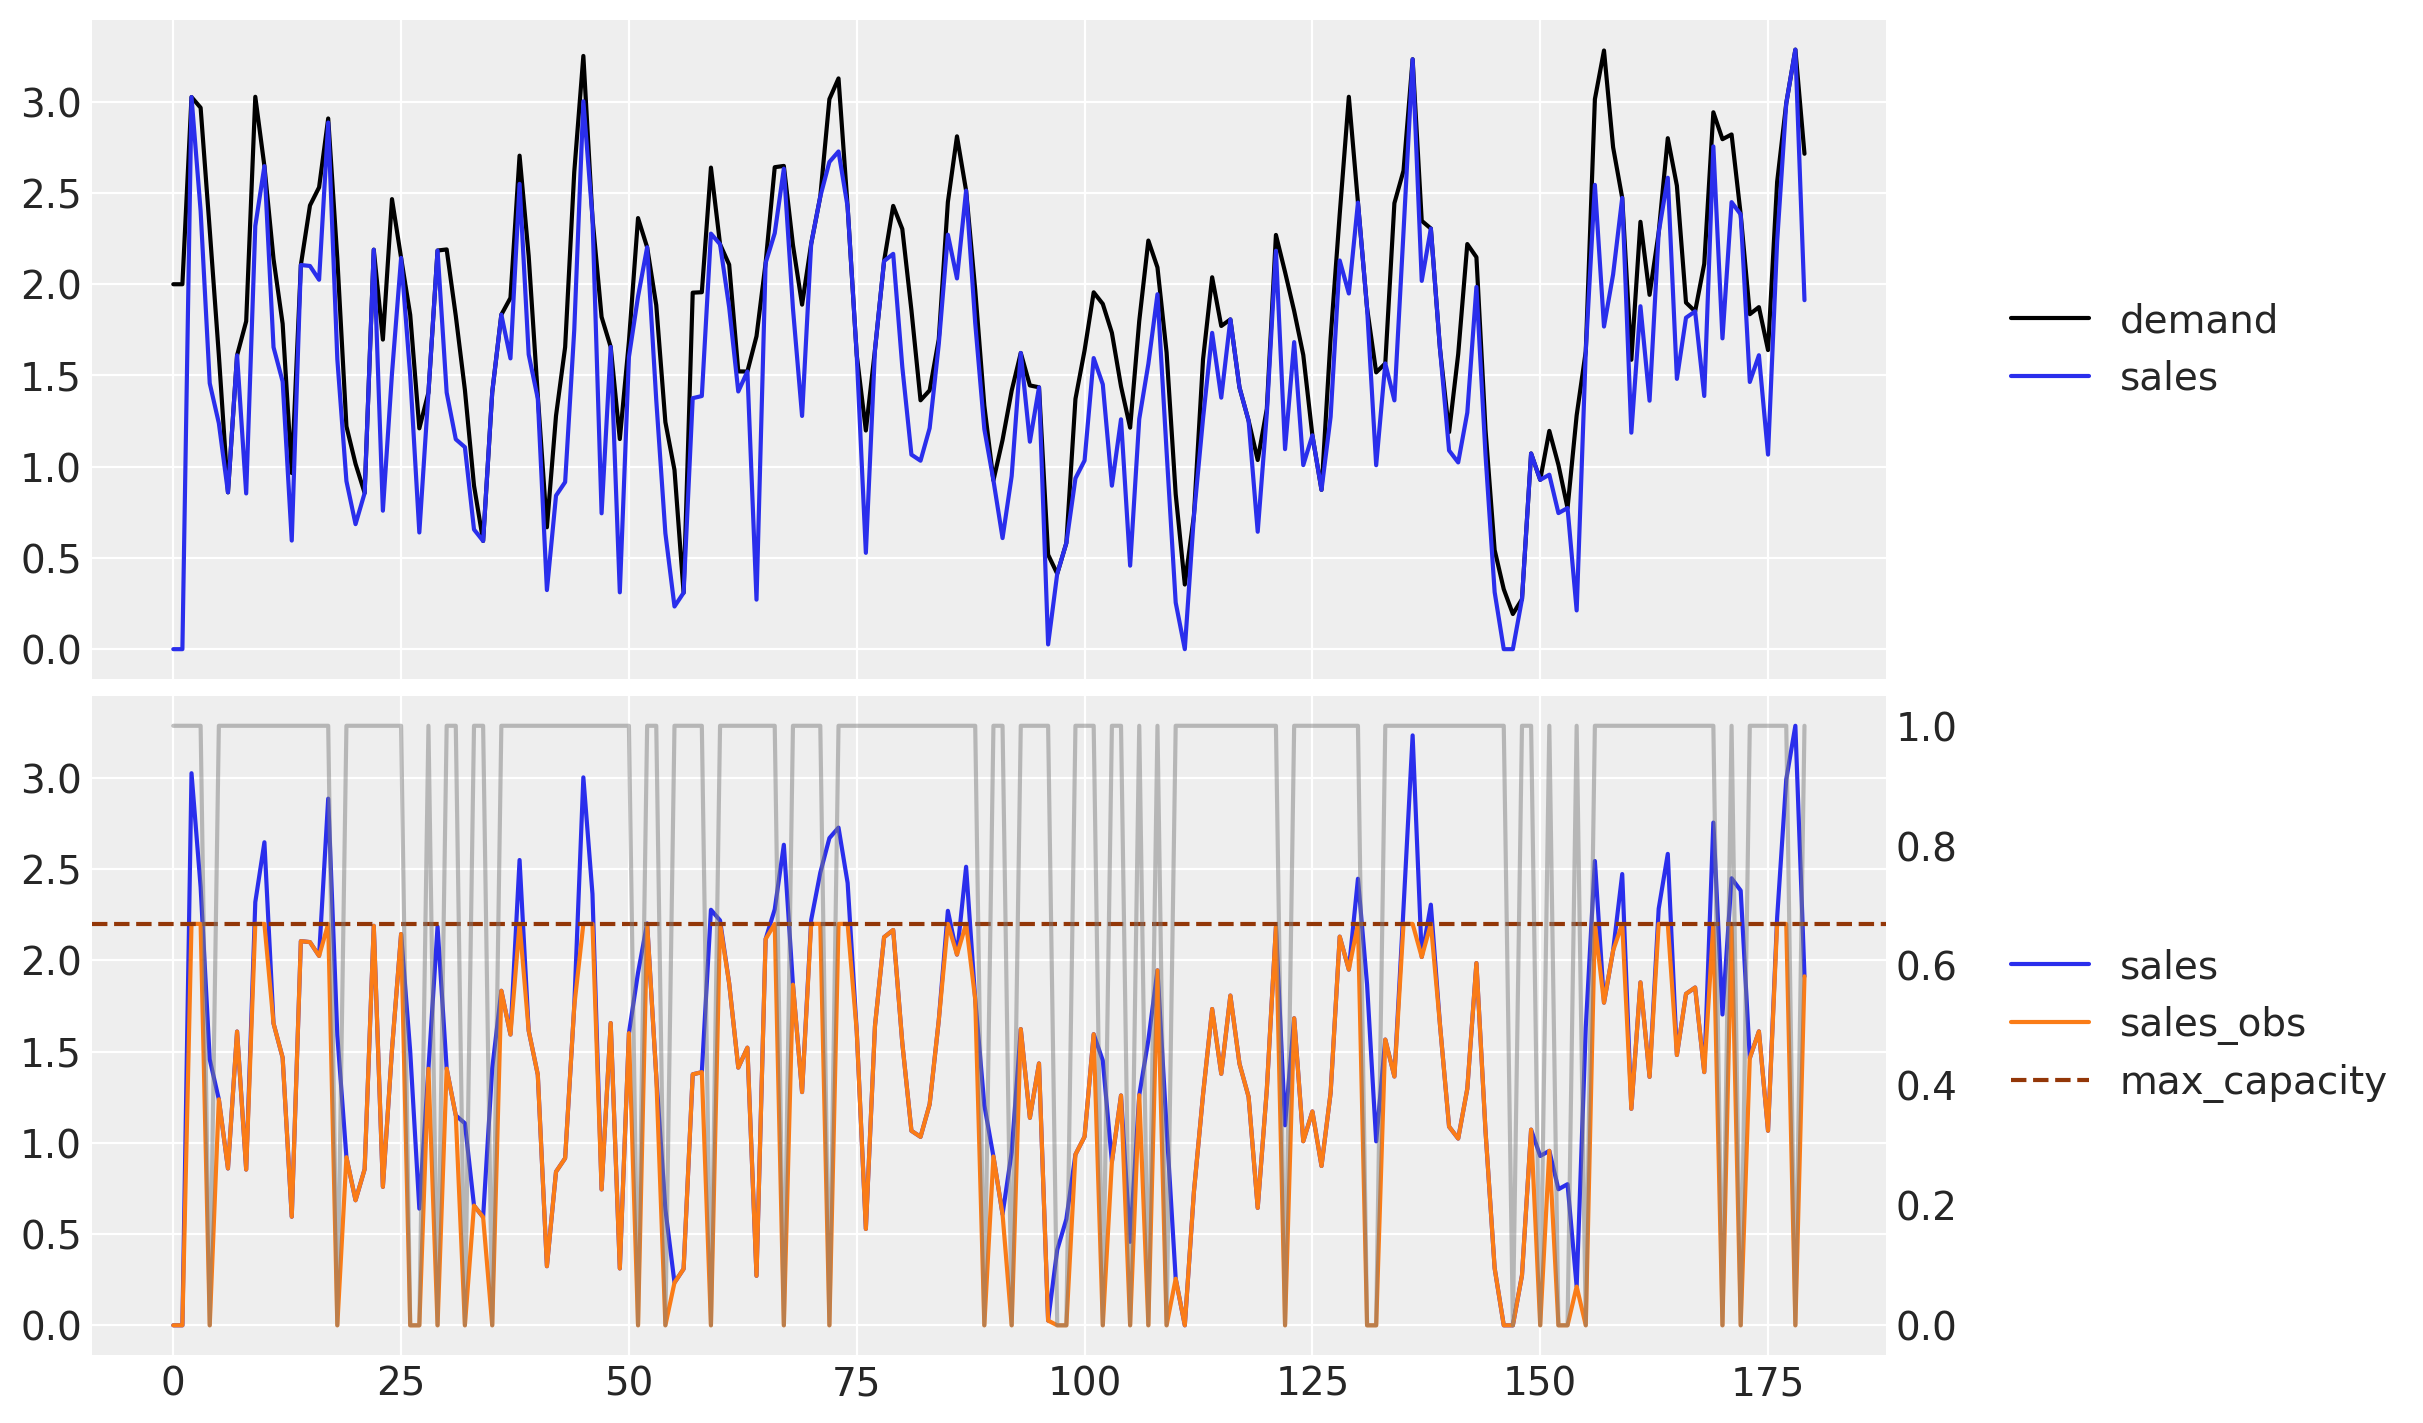

In [3]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].plot(t, demand, c="black", label="demand")
ax[0].plot(t, sales, c="C0", label="sales")
ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

ax[1].plot(t, sales, c="C0", label="sales")
ax[1].plot(t, sales_obs, c="C1", label="sales_obs")
ax1_twin = ax[1].twinx()
ax1_twin.plot(t, is_available, c="gray", alpha=0.5, label="is_available")
ax[1].axhline(2.2, color="C4", linestyle="--", label="max_capacity")
ax1_twin.grid(None)
ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5));

In [4]:
forecast_horizon = 30

t_train = t[:-forecast_horizon]
demand_train = demand[:-forecast_horizon]
sales_train = sales[:-forecast_horizon]
sales_obs_train = sales_obs[:-forecast_horizon]
is_available_train = is_available[:-forecast_horizon]
max_capacity_train = (sales_obs_train == 2.2).astype(int)

t_test = t[-forecast_horizon:]
demand_test = demand[-forecast_horizon:]
sales_test = sales[-forecast_horizon:]
sales_obs_test = sales_obs[-forecast_horizon:]
is_available_test = is_available[-forecast_horizon:]
is_available_test_expected = jnp.ones_like(is_available_test)
max_capacity_test_expected = jnp.zeros_like(sales_obs_test)

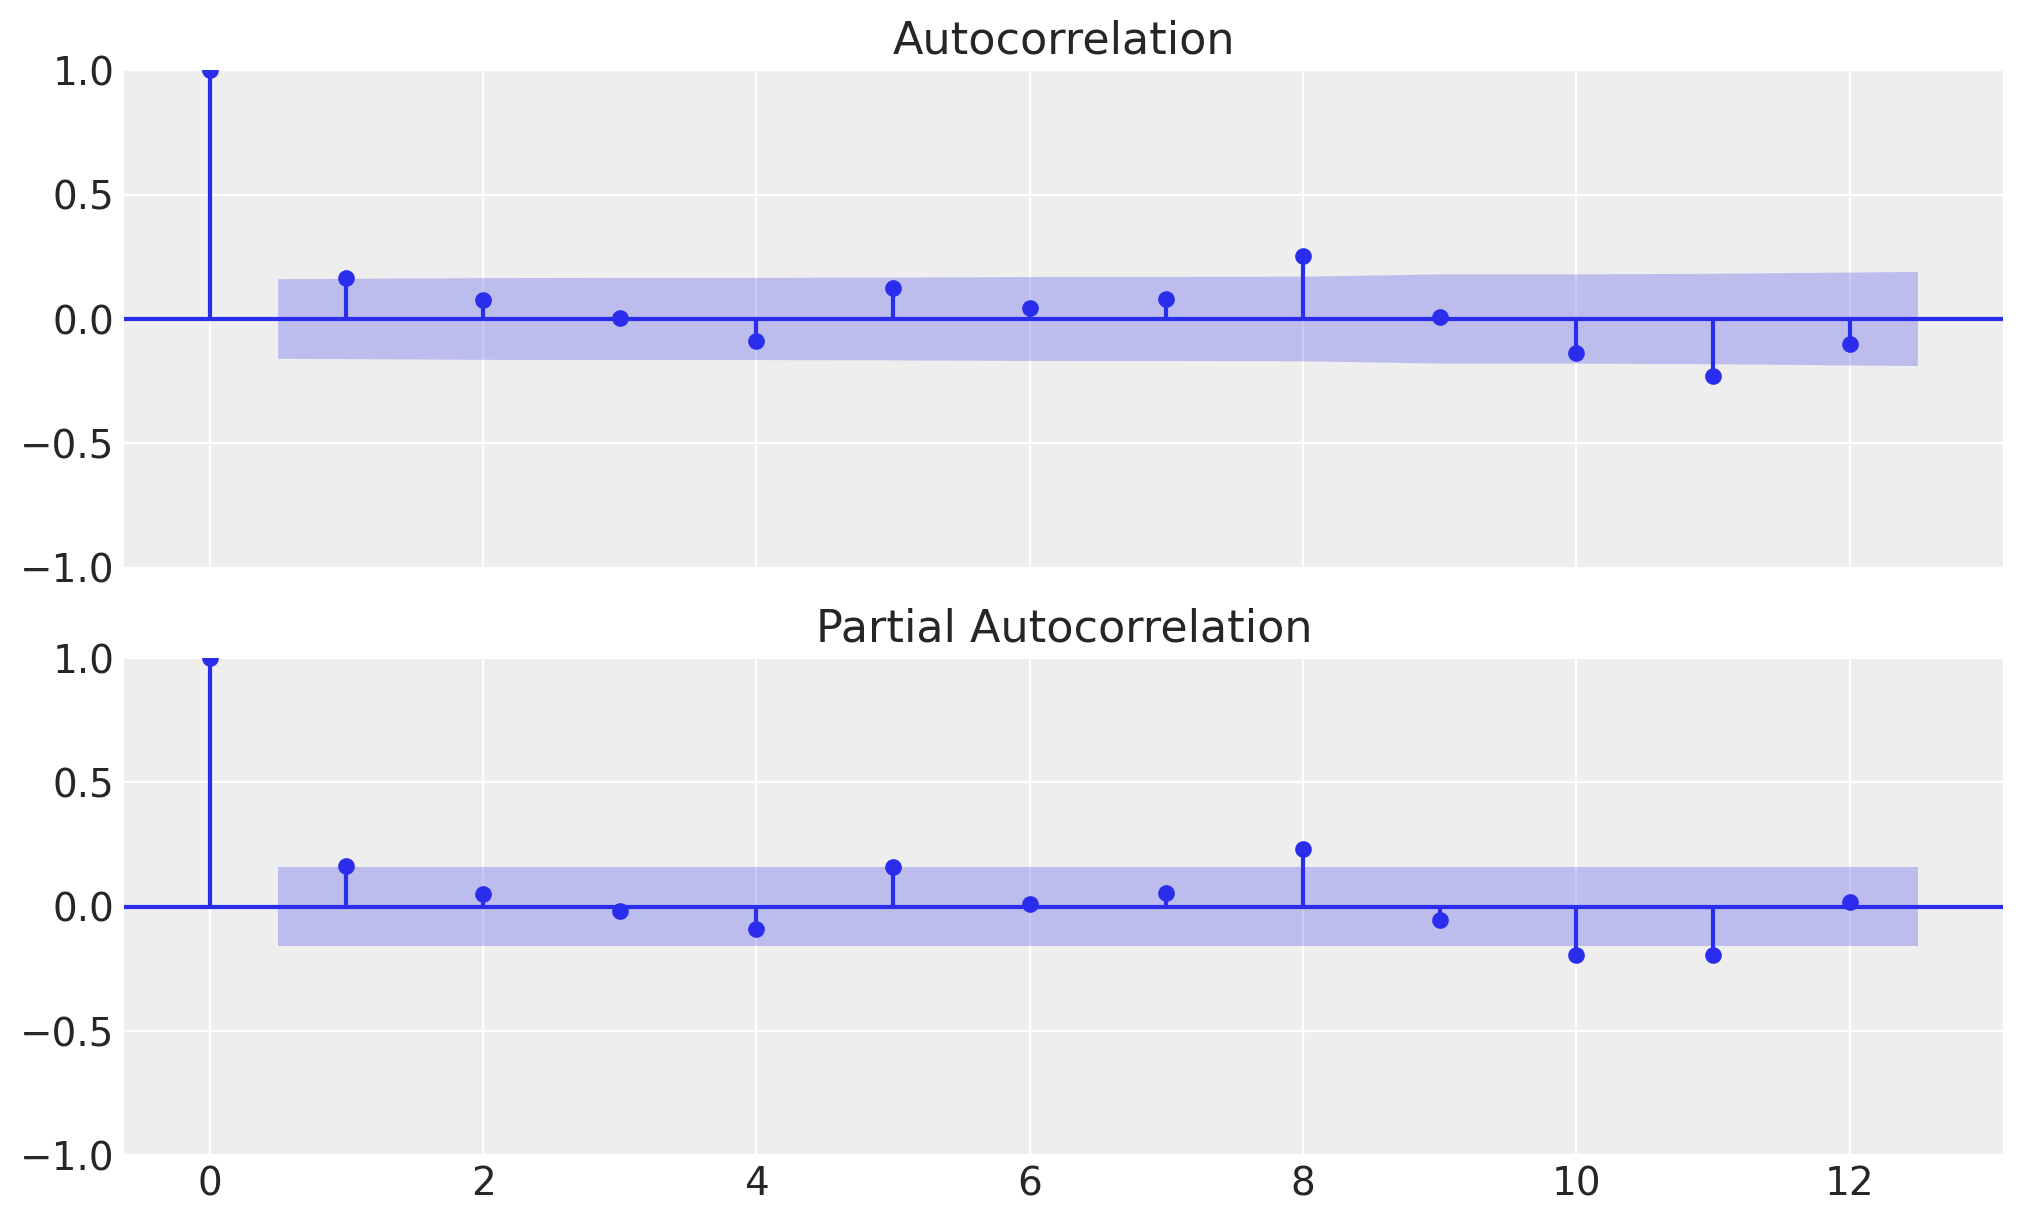

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 6), layout="constrained"
)

_ = plot_acf(sales_obs_train, lags=12, ax=ax[0])
_ = plot_pacf(sales_obs_train, lags=12, ax=ax[1])

In [6]:
n_order = 2
fourier_features_df = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * t * order / 7)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

fourier_features_train_df = fourier_features_df.iloc[: len(t_train)]
fourier_features_test_df = fourier_features_df.iloc[len(t_train) :]

In [7]:
fourier_features = jnp.array(fourier_features_df.to_numpy(), dtype=jnp.float32)

fourier_features_train = fourier_features[:-forecast_horizon]
fourier_features_test = fourier_features[-forecast_horizon:]

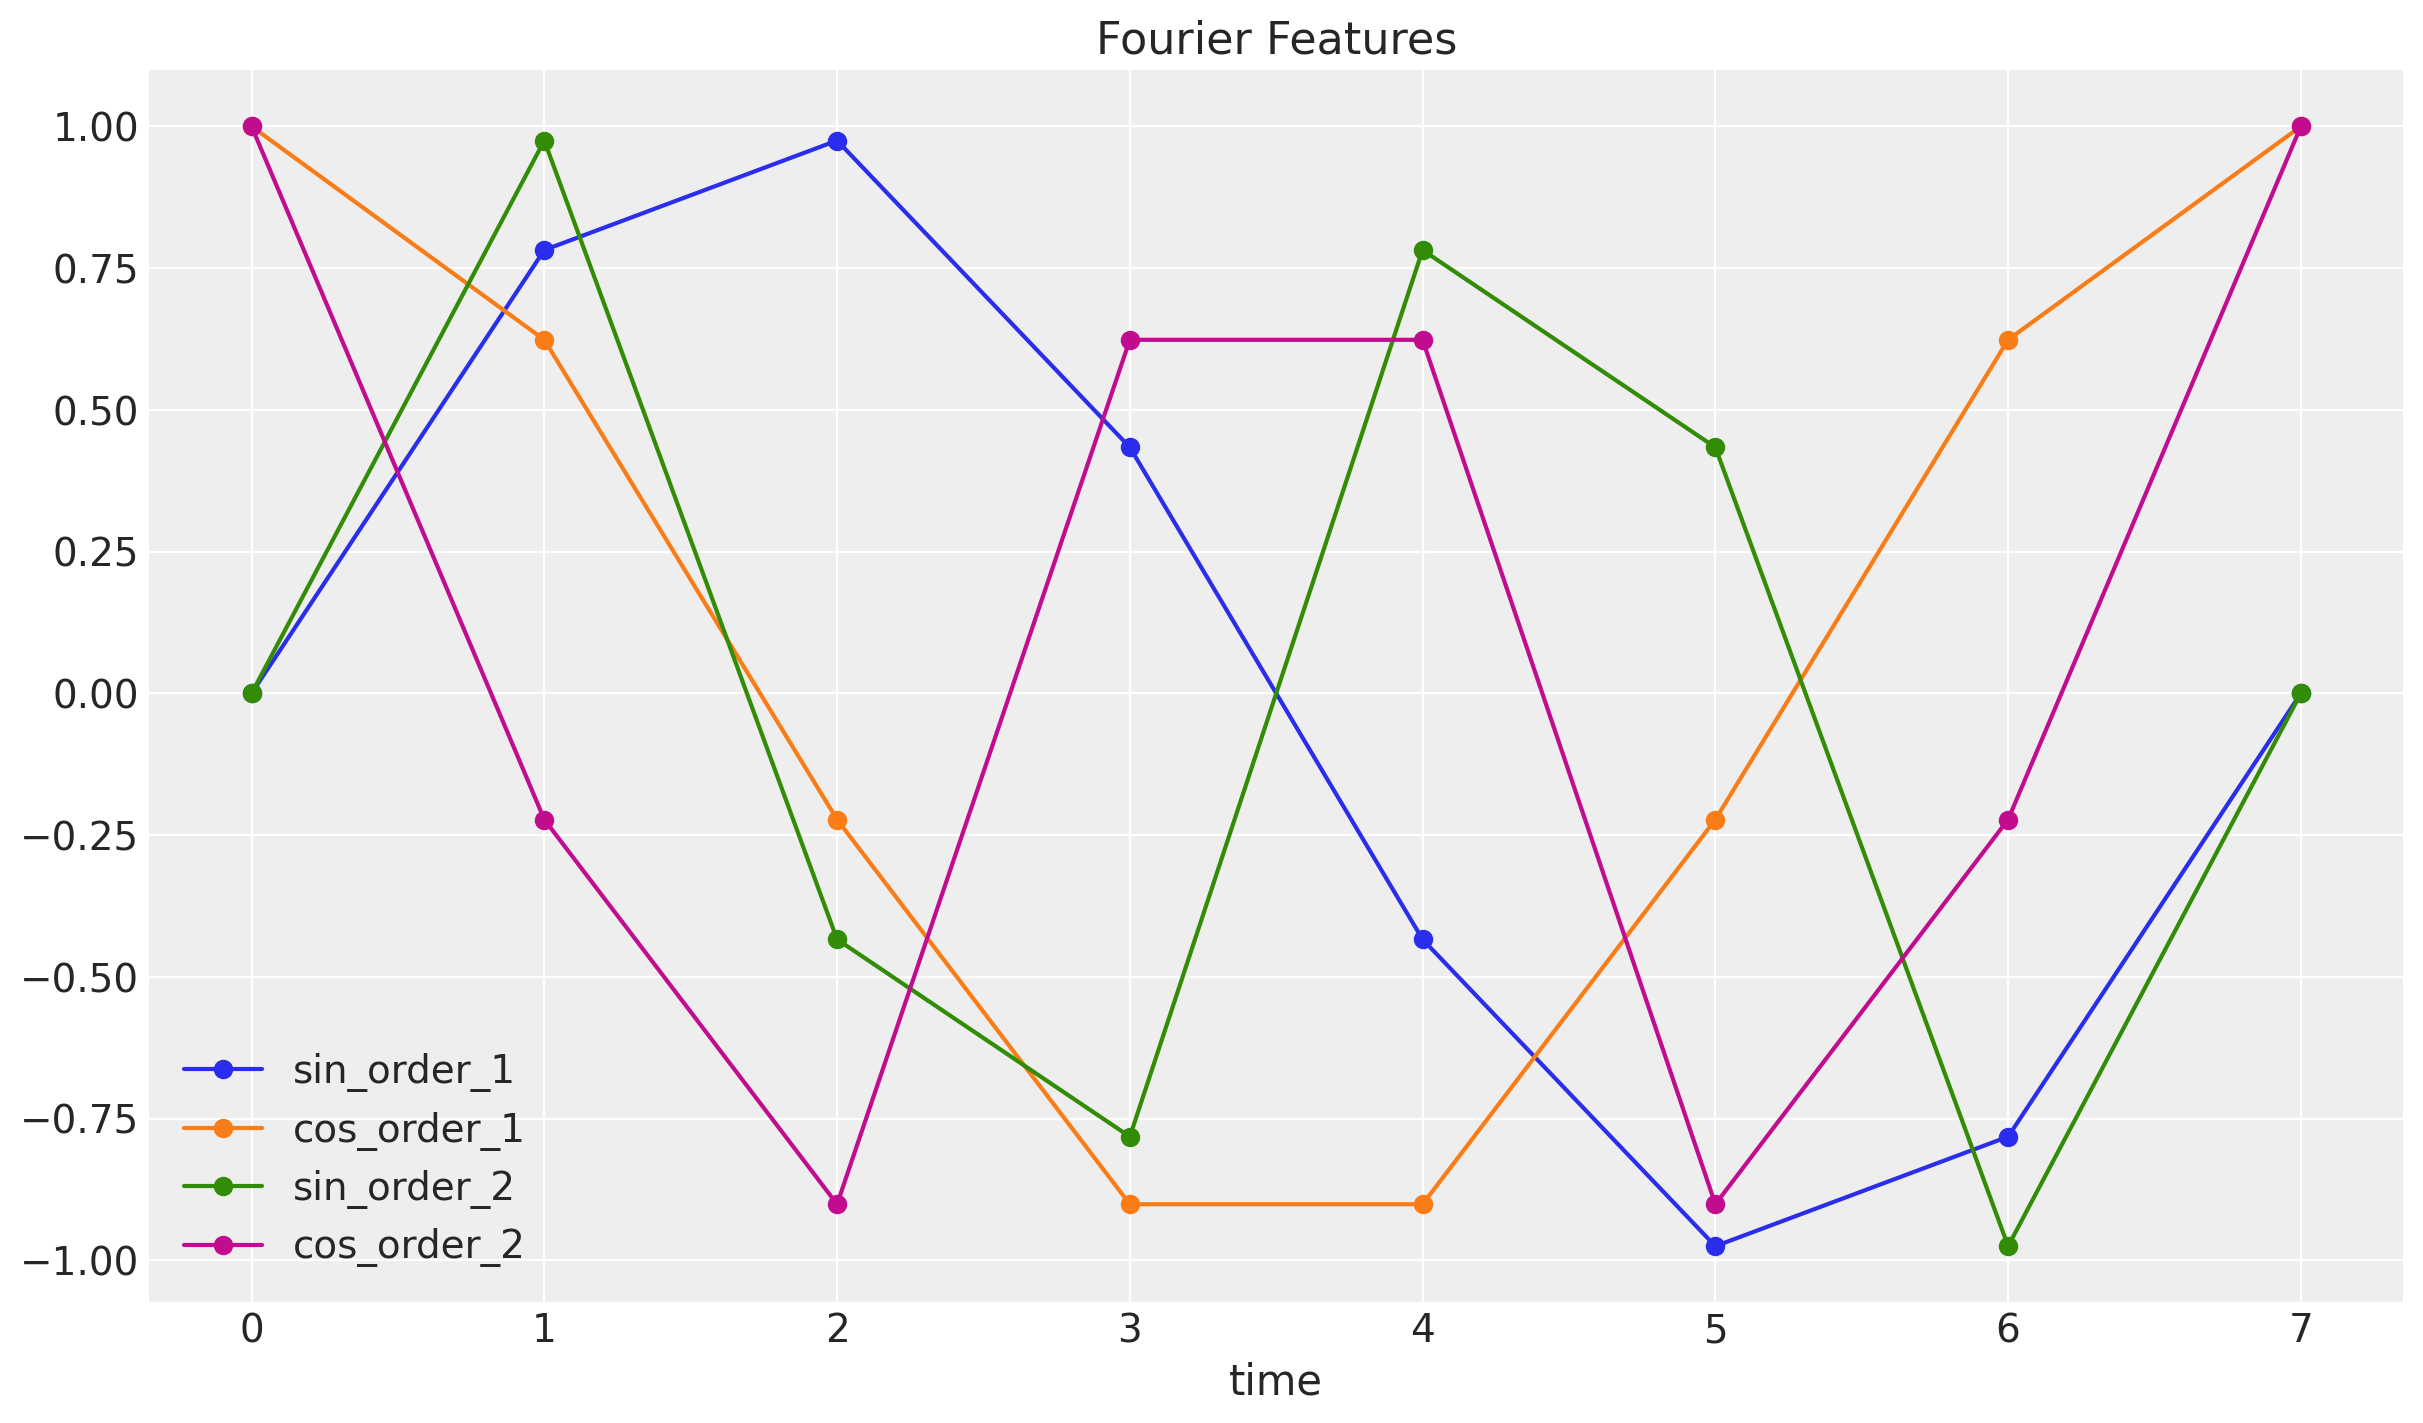

In [8]:
fig, ax = plt.subplots()
fourier_features_df.head(8).plot(marker="o", ax=ax)
ax.set(xlabel="time", ylabel=None, title="Fourier Features");

In [9]:
x_train_df = fourier_features_train_df
x_train_df = x_train_df.assign(is_available=is_available_train)

x_test_df = fourier_features_test_df
x_test_df = x_test_df.assign(is_available=is_available_test_expected)

In [10]:
model = ARIMA(
    endog=np.asarray(sales_obs_train),
    exog=x_train_df,
    order=(2, 0, 0),
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -104.116
Date:                Tue, 16 Apr 2024   AIC                            226.233
Time:                        16:00:43   BIC                            253.328
Sample:                             0   HQIC                           237.241
                                - 150                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0215      0.141      0.152      0.879      -0.256       0.299
sin_order_1      0.2626      0.060      4.387      0.000       0.145       0.380
cos_order_1     -0.3462      0.067     -5.204      0.000      -0.477      -0.216
sin_order_2      0.0002      0.052      0.005      0.996      -0.101       0.102
cos_order_2      0.0794      0.050      1.577      0.115      -0.019       0.178
is_available     1.3659      0.140      9.786      0.000       1.092       1.639
ar.L1            0.2085      0.073      2.875      0.004       0.066       0.351
ar.L2            0.1050      0.085      1.232      0.218      -0.062       0.272
sigma2           0.2345      0.033      7.131      0.000       0.170       0.299
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.88   Prob(JB):                         0.20
Heteroskedasticity (H):               0.70   Skew:                            -0.27
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

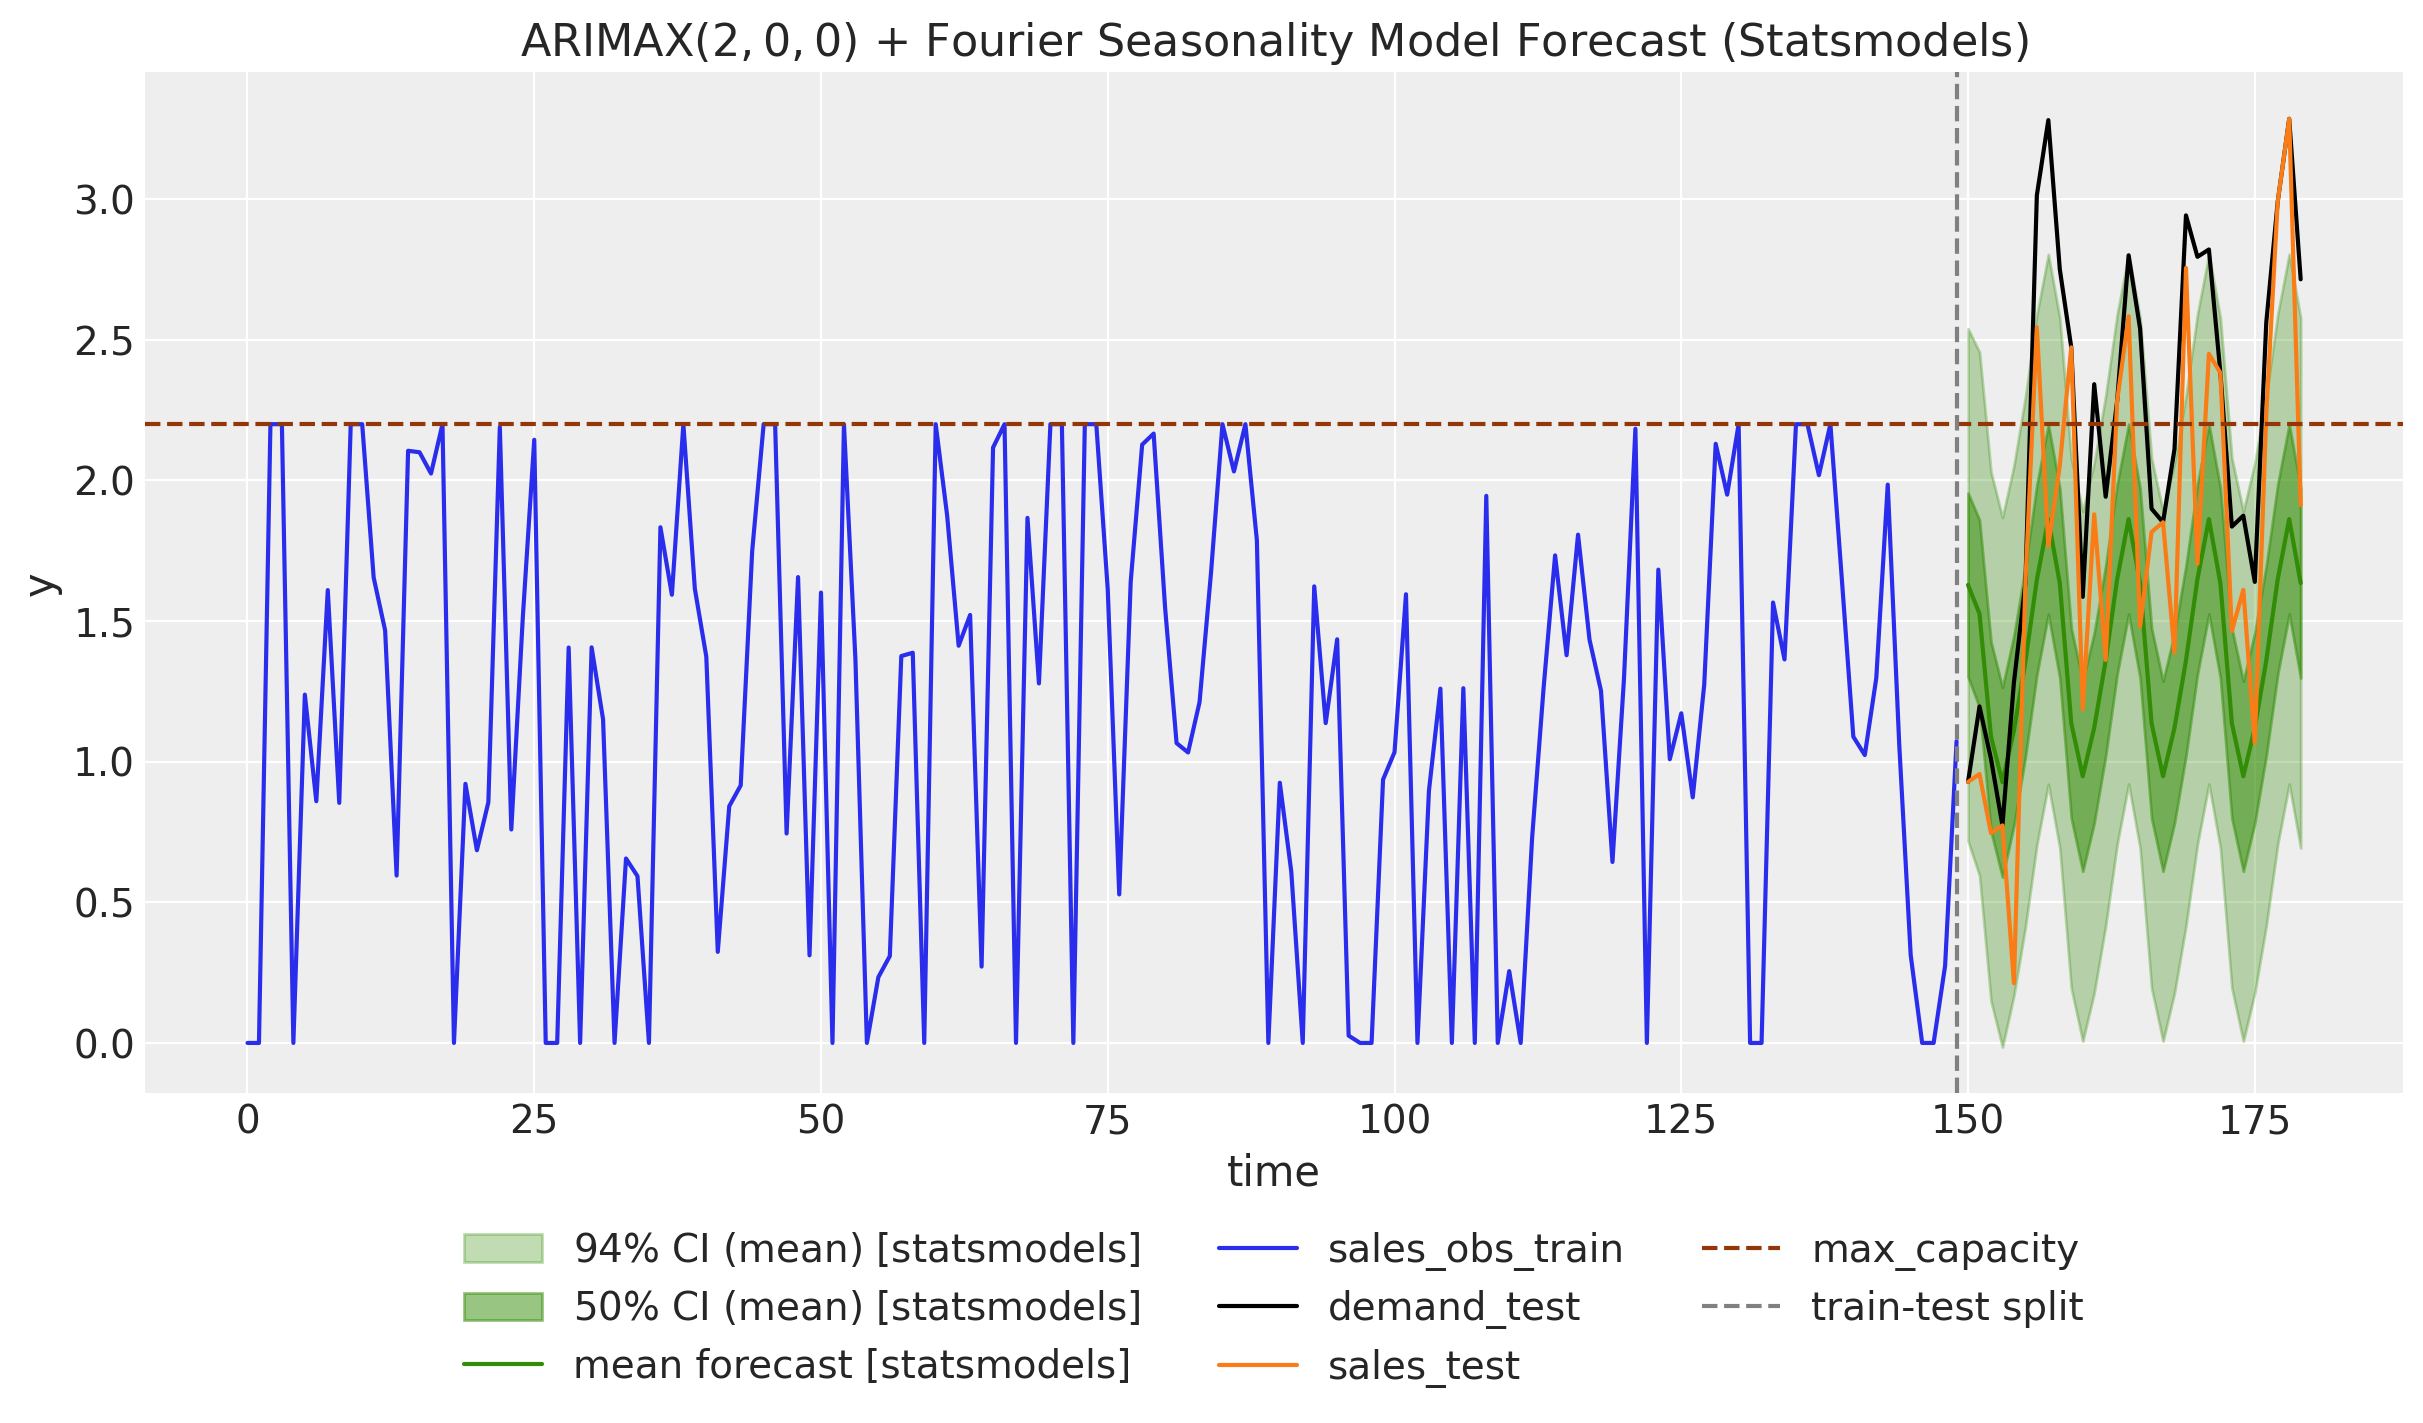

In [11]:
forecast_94_df = result.get_forecast(
    steps=sales_obs_test.size, exog=x_test_df
).summary_frame(alpha=0.06)

forecast_50_df = result.get_forecast(
    steps=sales_obs_test.size, exog=x_test_df
).summary_frame(alpha=0.5)

fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_94_df["mean_ci_lower"],
    forecast_94_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.fill_between(
    t_test,
    forecast_50_df["mean_ci_lower"],
    forecast_50_df["mean_ci_upper"],
    color="C2",
    alpha=0.5,
    label=r"$50\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=2.2, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(
    xlabel="time",
    ylabel="y",
    title="ARIMAX$(2, 0, 0)$ + Fourier Seasonality Model Forecast (Statsmodels)",
);

In [12]:
def seasonal_component(fourier_features):
    n_modes = fourier_features.shape[1]
    with numpyro.plate("seasonal_order", n_modes):
        beta_mode = numpyro.sample("beta_mode", dist.Normal(loc=0, scale=1))
    return jnp.dot(fourier_features, beta_mode)


def censored_normal(loc, scale, y, censored):
    distribution = dist.Normal(loc=loc, scale=scale)
    ccdf = 1 - distribution.cdf(y)
    numpyro.sample(
        "censored_label", dist.Bernoulli(probs=ccdf).mask(censored == 1), obs=censored
    )
    return numpyro.sample("pred", distribution.mask(censored != 1))


def ar2_seasonal(y, censored, is_available, fourier_features, future=0):
    t_max = y.size
    mu = numpyro.sample("mu", dist.Normal(loc=1, scale=1))
    phi_1 = numpyro.sample("phi_1", dist.Uniform(low=-1, high=1))
    phi_2 = numpyro.sample("phi_2", dist.Uniform(low=-1, high=1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    seasonal = seasonal_component(fourier_features)

    def transition_fn(carry, t):
        y_prev_1, y_prev_2 = carry
        ar_part = phi_1 * y_prev_1 + phi_2 * y_prev_2
        pred_mean = mu + ar_part + seasonal[t]

        pred = is_available[t] * censored_normal(pred_mean, sigma, y[t], censored[t])
        return (pred, y_prev_1), pred

    init = (y[1], y[0])
    timesteps = jnp.arange(t_max - 2 + future)

    with numpyro.handlers.condition(
        data={"pred": y[2:], "is_available": is_available[2:], "censored": censored[2:]}
    ):
        _, preds = scan(transition_fn, init, timesteps)

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

In [13]:
sampler = NUTS(ar2_seasonal, target_accept_prob=0.90)
mcmc = MCMC(sampler, num_warmup=1_000, num_samples=2_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(
    rng_key=rng_subkey,
    y=sales_obs_train,
    censored=max_capacity_train,
    is_available=is_available_train,
    fourier_features=fourier_features_train,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [14]:
idata = az.from_numpyro(posterior=mcmc)

print(f"Divergences: {idata.sample_stats.diverging.sum().item()}")

Divergences: 0


In [15]:
idata = az.from_numpyro(
    posterior=mcmc, coords={"t_train": t_train[2:]}, dims={"pred": ["t_train"]}
)

var_names = ["mu", "phi_1", "phi_2", "beta_mode", "sigma"]

az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu            0.939  0.148   0.655    1.207      0.002    0.001    5973.0   
phi_1         0.082  0.091  -0.091    0.247      0.001    0.001    7810.0   
phi_2         0.382  0.092   0.213    0.559      0.001    0.001    7407.0   
beta_mode[0]  0.134  0.111  -0.072    0.348      0.001    0.001    7248.0   
beta_mode[1]  0.257  0.104   0.069    0.453      0.001    0.001   10009.0   
beta_mode[2] -0.026  0.101  -0.219    0.160      0.001    0.001    9689.0   
beta_mode[3]  0.103  0.101  -0.088    0.292      0.001    0.001   10166.0   
sigma         0.842  0.057   0.734    0.947      0.001    0.000    8660.0   

              ess_tail  r_hat  
mu              5995.0    1.0  
phi_1           5772.0    1.0  
phi_2           5526.0    1.0  
beta_mode[0]    6497.0    1.0  
beta_mode[1]    6170.0    1.0  
beta_mode[2]    4938.0    1.0  
beta_mode[3]    5384.0    1.0  
sigma           5673.0    1.0

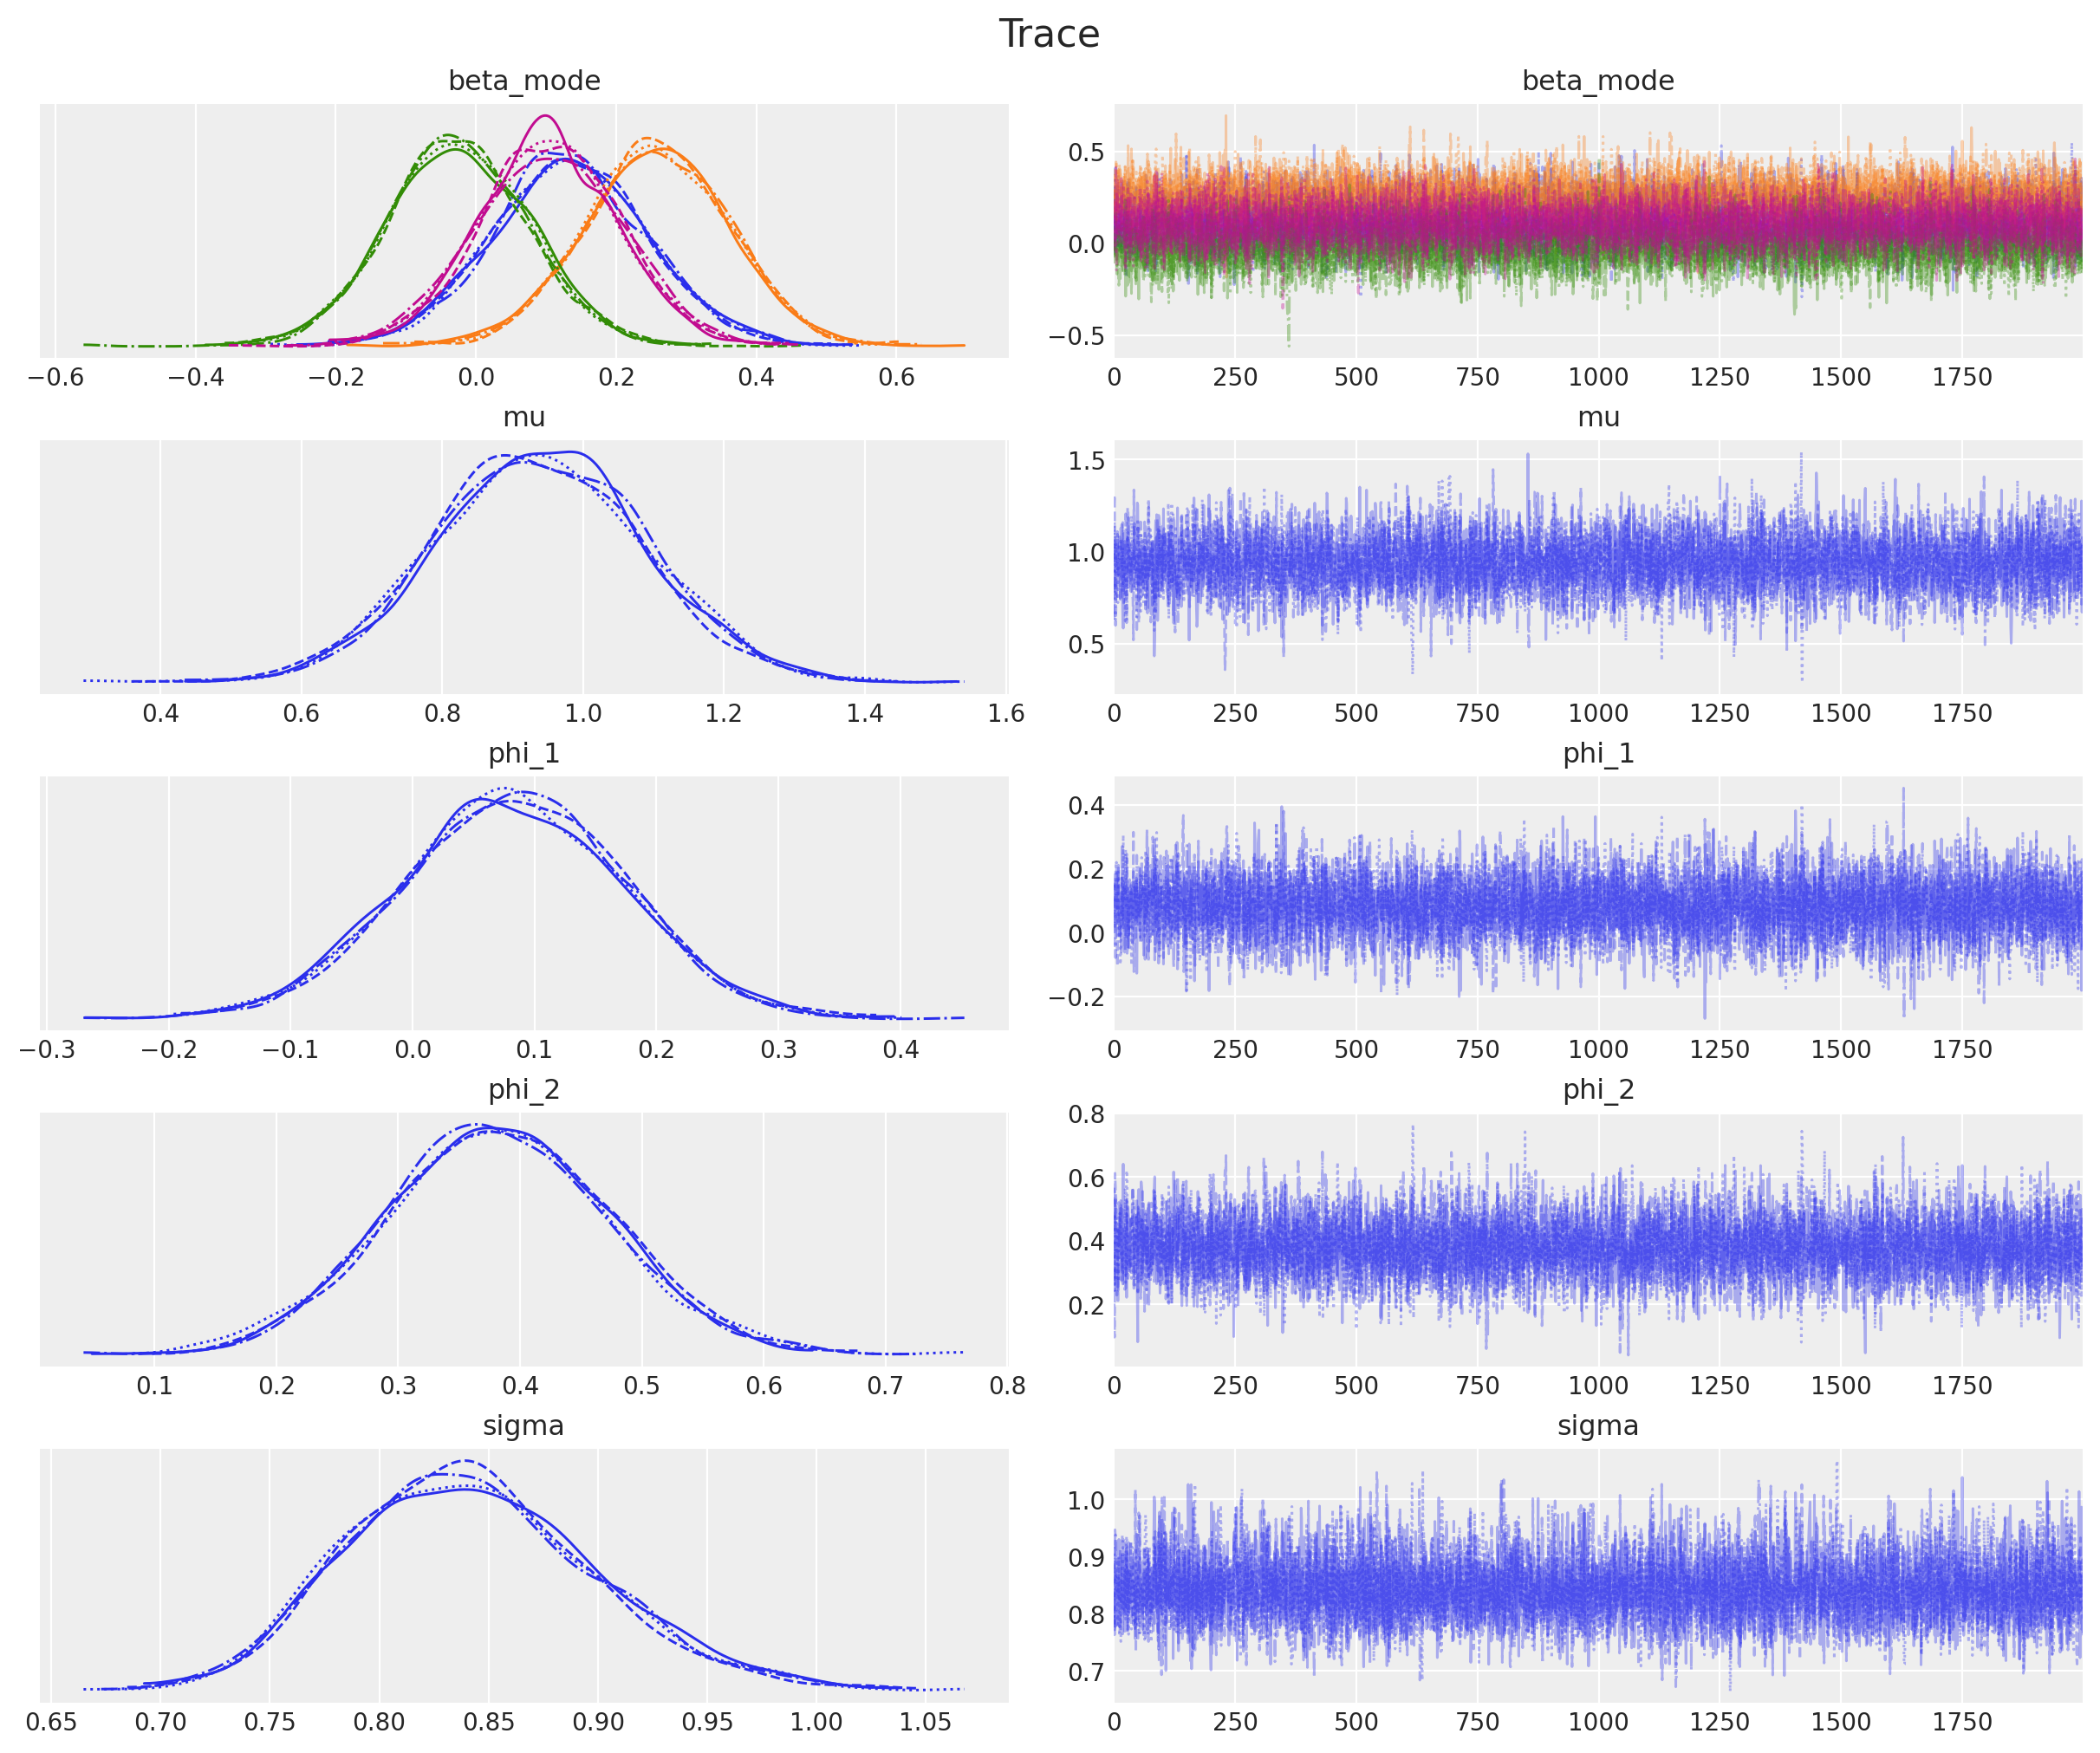

In [16]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16);

In [17]:
predictive = Predictive(
    model=ar2_seasonal,
    posterior_samples=mcmc.get_samples(),
    return_sites=["y_forecast"],
)
rng_key, rng_subkey = random.split(rng_key)
forecast = predictive(
    rng_subkey,
    y=sales_obs_train,
    censored=jnp.concat([max_capacity_train, max_capacity_test_expected], axis=0),
    is_available=jnp.concatenate([is_available_train, is_available_test_expected]),
    fourier_features=jnp.concatenate([fourier_features_train, fourier_features_test]),
    future=forecast_horizon,
)

In [18]:
idata.extend(
    az.from_numpyro(
        posterior_predictive=forecast,
        coords={"t_test": t_test, "t": t},
        dims={"y_forecast": ["t_test"]},
    )
)

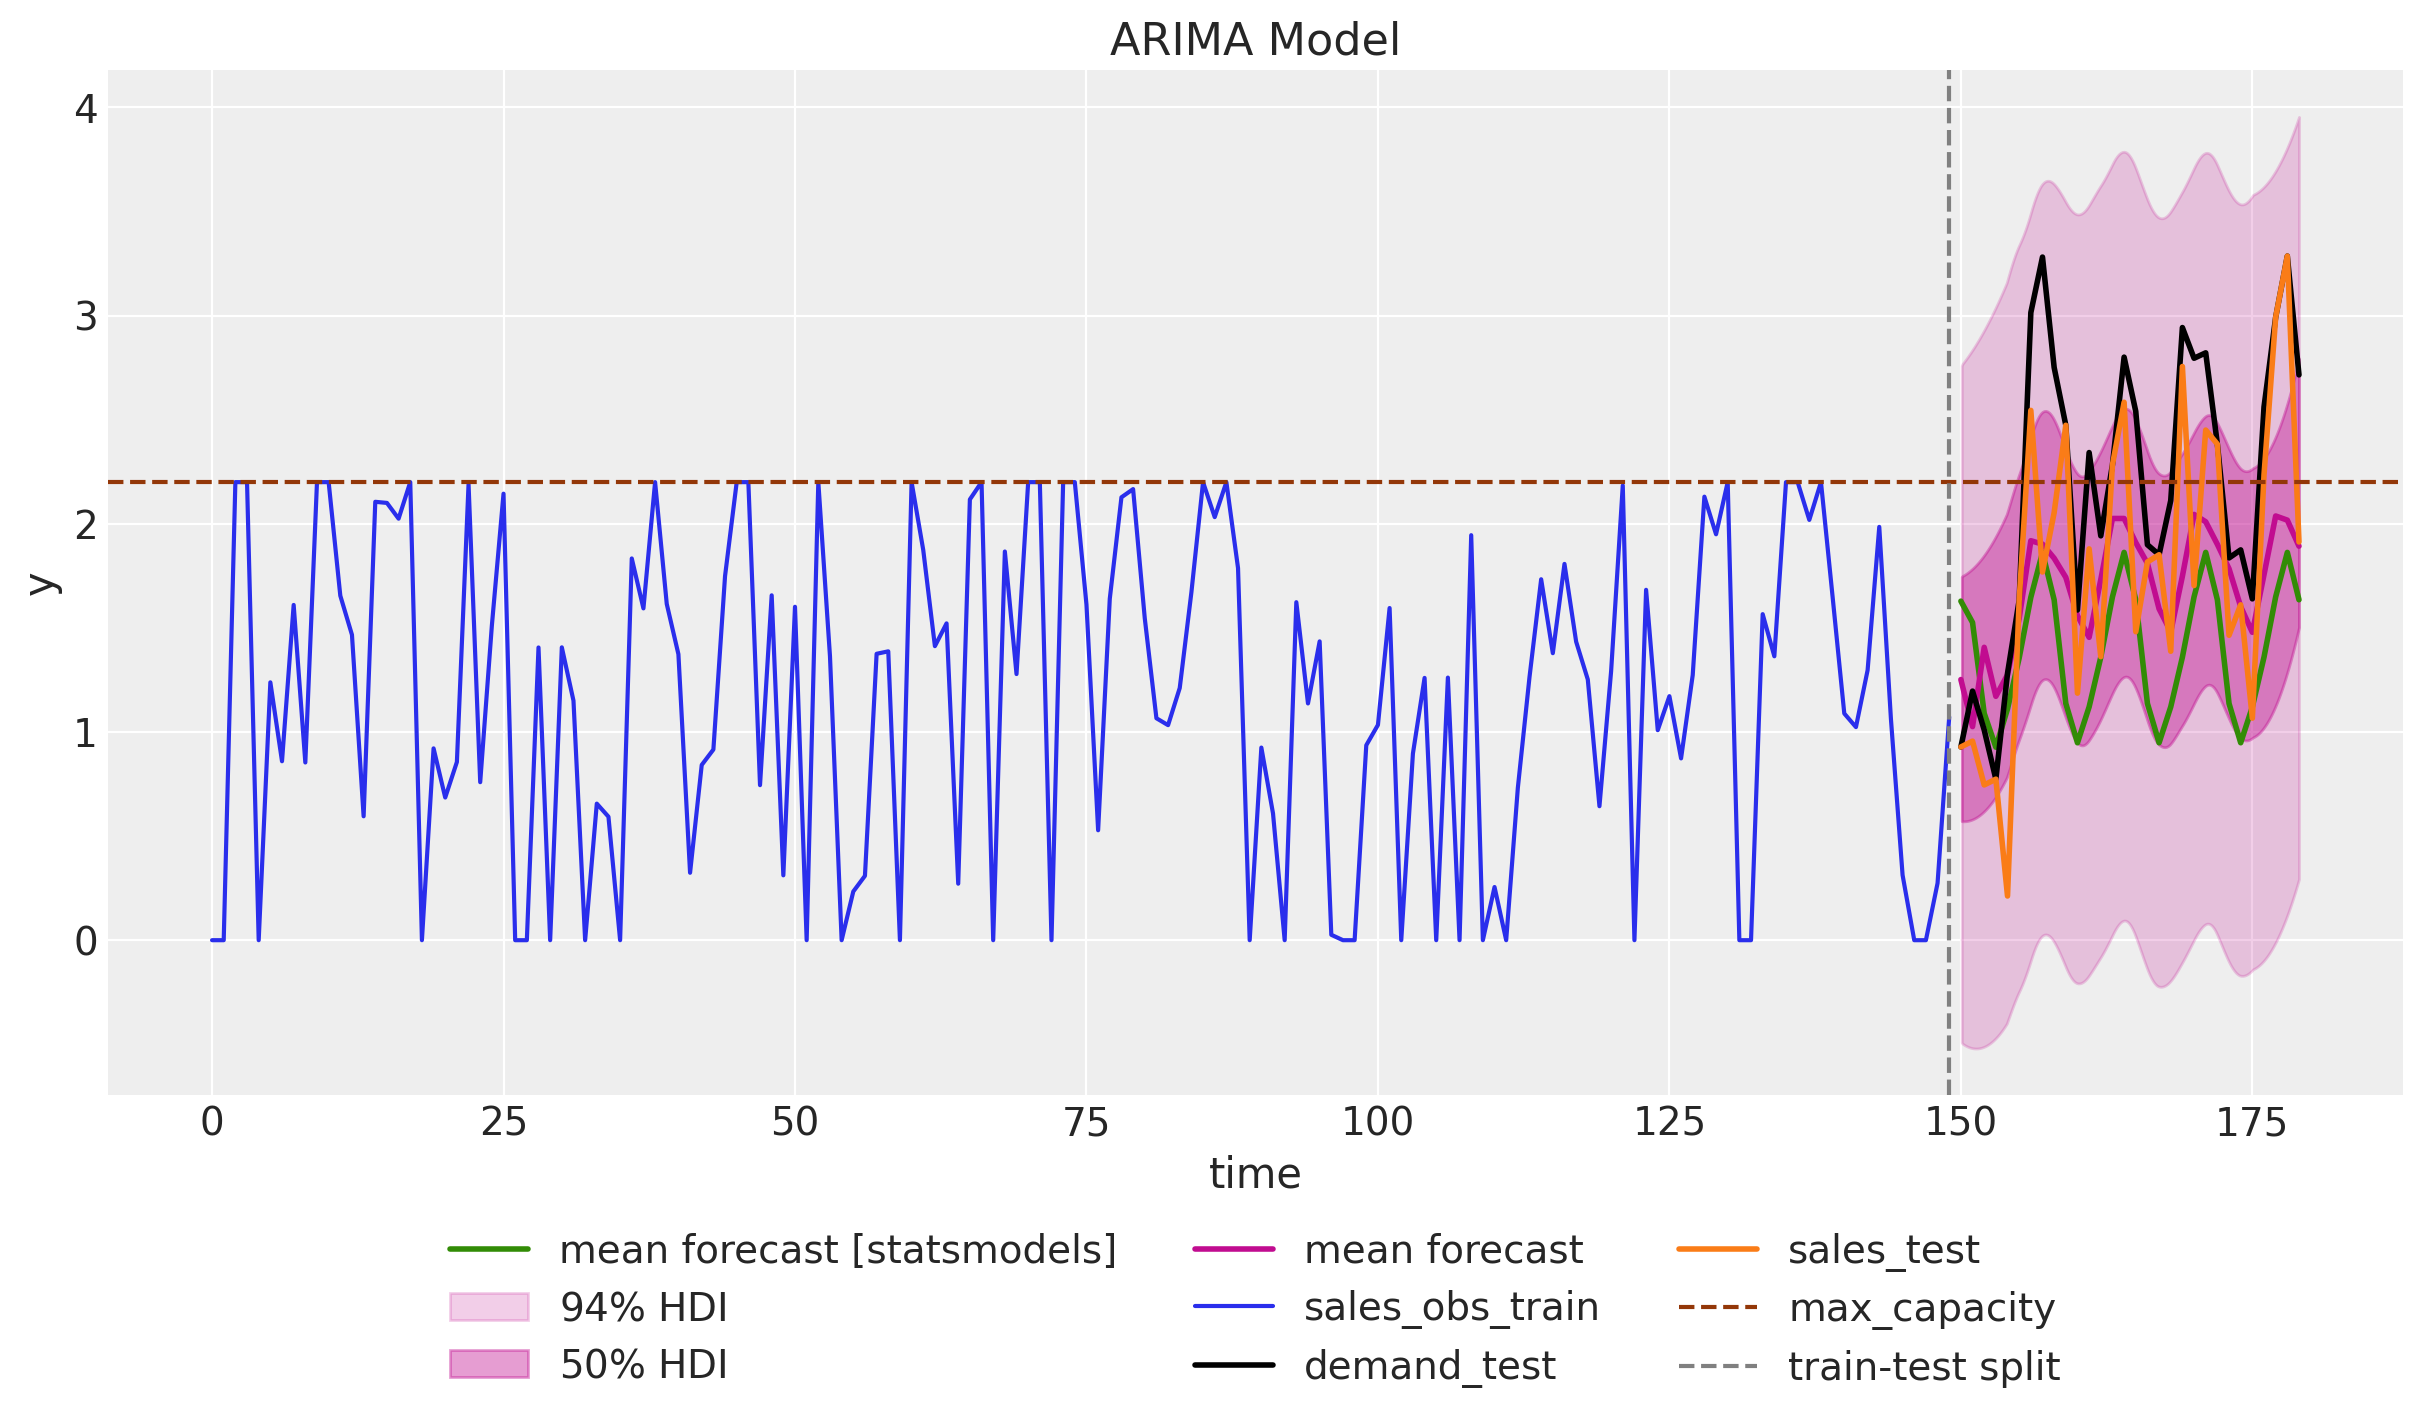

In [39]:
fig, ax = plt.subplots()
ax.plot(
    t_test,
    forecast_94_df["mean"],
    linewidth=2,
    color="C2",
    label="mean forecast [statsmodels]",
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    hdi_prob=0.50,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HDI"},
)
ax.plot(
    t_test,
    idata.posterior_predictive["y_forecast"].mean(dim=("chain", "draw")),
    linewidth=2,
    color="C3",
    label="mean forecast",
)
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", linewidth=2, label="demand_test")
ax.plot(t_test, sales_test, color="C1", linewidth=2, label="sales_test")
ax.axhline(y=2.2, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="time", ylabel="y", title="ARIMA Model");